# Residual Integration Neural Net

# Problem statement :

Let us consider a dynamical system, whose time-varying state $X_t$ is governed by the following ordinary differential equation (ODE):

\begin{equation}
\frac{dX_t}{dt}= F(t,X_t)
\label{eq:sys dyn}
\end{equation}

where $F$ is the dynamical operator. Most of the time, this ODE cannot be solved analytically and numerical integration techniques using discrete approximations are implemented. 

In this work, we focus on explicit integration schemes. A one-step explicit integration scheme is defined as: 

\begin{equation}
\label{eq:int_gen_schm}
X_{t_{n+1}} = X_{t_{n}} + h\Phi(t_{n},X_{t_{n}},h)
\end{equation}

with $\Phi(t_{n},X_{t_{n}},h)$ a numerical integration operator. Here, we aim to learn a prediction operator based on $\Phi$ and an approximation of the dynamical model $F(t,X_t)$ so that the forecasting error (typically, a one-step-ahead error) is minimized.

In this notebook, will learn an approximation $\Phi$, $F(t,X_t)$ known

In [1]:
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes')
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from utils import Comput_LyapunovRINN
def RMSE(a,b): 
    return np.sqrt(np.mean((a-b)**2))
from tqdm import tqdm

In [2]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 4000.8 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
init_cat = catalog.analogs
#training data
batch_size = 100


In [3]:
order=4 #number of stages of the runge kutta scheme
device = 'cpu'
params = {}#NN parameters 
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['ntrain']=[0,1000]
params['lr']=0.001
pretrained = False

# Learn models for the Lorenz 63 model

In [4]:
y_pred_all = []
lyap_exp_all = []
lyap_dim_all = []
a_all = []
b_all = []
c_all = []
for i in [0.1,0.15,0.16,0.17,0.18,0.19]:
    print('training ADRK model with h = ',i)
    path = 'RINN_L63_dt_integration_'+str(i)+'_order_4_known_mdl.pt'
    new_dt = i
    GD.dt_integration = new_dt
    params['dt_integration']=GD.dt_integration
    keep_ratio = int(new_dt/0.01)
    catalog.analogs    = init_cat[::keep_ratio,:][:10*keep_ratio*batch_size+1,:][:-1]
    catalog.successors = init_cat[::keep_ratio,:][:10*keep_ratio*batch_size+1,:][1:]
    xt.values          = xt.values[::keep_ratio,:]
    X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
    Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
    Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

    np.random.seed(0)
    torch.manual_seed(0)
    class applyRK_Constraints(object):
            def __init__(self, frequency=1):
                self.frequency = frequency

            def __call__(self, module):
                if hasattr(module, 'b'):
                    module.b.data = (torch.abs(module.b.data))
                    module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
                if hasattr(module, 'c'):
                    module.c.data = module.c.data
                    module.c.data[:,0] = 0
                    module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
    class FC_net_true(torch.nn.Module):
            def __init__(self, params):
                super(FC_net_true, self).__init__()
            def forward(self, inp):
                """
                In the forward function we accept a Tensor of input data and we must return
                a Tensor of output data. We can use Modules defined in the constructor as
                well as arbitrary operators on Tensors.
                """
                arg = [GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta]
                grad = Variable(torch.zeros((inp.size())))
                grad[:,0] = arg[0]*(inp[:,1]-inp[:,0]);
                grad[:,1] = inp[:,0]*(arg[1]-inp[:,2])-inp[:,1];
                grad[:,2] = inp[:,0]*inp[:,1] - arg[2]*inp[:,2];
    #            dS  = np.array([x_1,x_2,x_3]);
    #            grad = self.outputLayer(aug_vect)
                return grad
    model_true  = FC_net_true(params)

    class FC_net_true_L96(torch.nn.Module):
            def __init__(self, params):
                super(FC_net_true_L96, self).__init__()
            def forward(self, S):
                """
                In the forward function we accept a Tensor of input data and we must return
                a Tensor of output data. We can use Modules defined in the constructor as
                well as arbitrary operators on Tensors.
                """
                J = 40
                F = 8
                x = torch.zeros(S.shape[0],J).to(device);
                x[:,0] = (S[:,1]-S[:,J-2])*S[:,J-1]-S[:,0];
                x[:,1] = (S[:,2]-S[:,J-1])*S[:,0]-S[:,1];
                x[:,J-1] = (S[:,0]-S[:,J-3])*S[:,J-2]-S[:,J-1];
                for j in range(2,J-1):
                    x[:,j] = (S[:,j+1]-S[:,j-2])*S[:,j-1]-S[:,j];
                dS = x + F;
    #            dS  = np.array([x_1,x_2,x_3]);
    #            grad = self.outputLayer(aug_vect)
                return dS
    model_true_L96  = FC_net_true_L96(params).to(device)

    class FC_net(torch.nn.Module):
            def __init__(self, params):
                super(FC_net, self).__init__()
                self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']).to(device) 
                self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
                self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
                augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
                self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output']).to(device)])
                self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']).to(device) for i in range(1, params['transition_layers'])])
                self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']).to(device)
            def forward(self, inp):
                """
                In the forward function we accept a Tensor of input data and we must return
                a Tensor of output data. We can use Modules defined in the constructor as
                well as arbitrary operators on Tensors.
                """
                BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])).to(device))
                L_outp   = self.linearCell(inp)
                for i in range((params['bi_linear_layers'])):
                    BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
                aug_vect = torch.cat((L_outp, BP_outp), dim=1)
                for i in range((params['transition_layers'])):
                    aug_vect = (self.transLayers[i](aug_vect))
                grad = self.outputLayer(aug_vect)
                return grad
    model  = FC_net(params).to(device)
    
    class INT_net(torch.nn.Module):
            def __init__(self, params,order):
                super(INT_net, self).__init__()
                self.Dyn_net = model_true#model
                self.Dyn_net_True = model_true.to(device)
                self.Dyn_net_True_L96 = model_true_L96.to(device)
                a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
                b = 0.*np.random.uniform(size=(1,order))
                c = 0.01*np.random.uniform(size=(1,order))
                self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float().to(device),requires_grad = True).to(device)
                self.b = torch.nn.Parameter(torch.from_numpy(b).float().to(device),requires_grad = True).to(device)
                self.c = torch.nn.Parameter(torch.from_numpy(c).float().to(device),requires_grad = True).to(device)
            def lin_flow(self, inp, dt, order):
                k = [(self.Dyn_net_lin(inp))]
                for i in range(1,order):
                    coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                    for j in range(0,i):
                        if j ==0:
                            if i == 1:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                            else:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                        else :
                            coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                    rk_inp = inp+dt*coef_sum        
                    k.append(self.Dyn_net_lin(rk_inp))
                pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for i in range(0,order): 
                    pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
                pred = inp +dt*pred_sum
                gain = pred[0,:]/(inp[0,:])
                return pred ,k[0], gain 
            def flow_True_Model(self, inp, dt, order):
                """
                In the forward function we accept a Tensor of input data and we must return
                a Tensor of output data. We can use Modules defined in the constructor as
                well as arbitrary operators on Tensors.
                """
                k = [(self.Dyn_net_True(inp))]
                for i in range(1,order):
                    coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                    for j in range(0,i):
                        if j ==0:
                            if i == 1:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                            else:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                        else :
                            coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                    rk_inp = inp+dt*coef_sum        
                    k.append(self.Dyn_net_True(rk_inp))
                pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for i in range(0,order): 
                    pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
                pred = inp +dt*pred_sum
                return pred ,k[0], inp
            def flow_True_Model_L96(self, inp, dt, order):
                """
                In the forward function we accept a Tensor of input data and we must return
                a Tensor of output data. We can use Modules defined in the constructor as
                well as arbitrary operators on Tensors.
                """
                k = [(self.Dyn_net_True_L96(inp))]
                for i in range(1,order):
                    coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                    for j in range(0,i):
                        if j ==0:
                            if i == 1:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                            else:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                        else :
                            coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                    rk_inp = inp+dt*coef_sum        
                    k.append(self.Dyn_net_True_L96(rk_inp))
                pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for i in range(0,order): 
                    pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
                pred = inp +dt*pred_sum
                return pred ,k[0], inp        
            def flow_RK45_True_Model(self, inp,dt,order = 4):
                k1    = self.Dyn_net_True(inp)
                inp_k2 = inp + 0.5*dt*k1
                k2  = self.Dyn_net_True(inp_k2)
                inp_k3 = inp + 0.5*dt*k2       
                k3   = self.Dyn_net_True(inp_k3)
                inp_k4 = inp + dt*k3          
                k4   = self.Dyn_net_True(inp_k4)            
                pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
                return pred, k1     
            def flow_RK45_True_Model_L96(self, inp,dt,order = 4):
                k1    = self.Dyn_net_True_L96(inp)
                inp_k2 = inp + 0.5*dt*k1
                k2  = self.Dyn_net_True_L96(inp_k2)
                inp_k3 = inp + 0.5*dt*k2       
                k3   = self.Dyn_net_True_L96(inp_k3)
                inp_k4 = inp + dt*k3          
                k4   = self.Dyn_net_True_L96(inp_k4)            
                pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
                return pred, k1    
            def flow_RK45(self, inp,dt,order = 4):
                k1    = self.Dyn_net(inp)
                inp_k2 = inp + 0.5*dt*k1
                k2  = self.Dyn_net(inp_k2)
                inp_k3 = inp + 0.5*dt*k2       
                k3   = self.Dyn_net(inp_k3)
                inp_k4 = inp + dt*k3          
                k4   = self.Dyn_net(inp_k4)            
                pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
                return pred, k1        
            def opti_gain_lin(self, h_int, inp, order):
                gain = Variable(torch.zeros(h_int.size()).float().to(device))
                for i in range(h_int.shape[0]):
                    pred ,tmp, tmpp =self.lin_flow(inp, h_int[i], order)
                    gain[i] = tmpp[0]
                    del pred, tmp, tmpp
                return gain
            def implicit_scheme(self, inp, inpt1, dt, order):
                """
                In the forward function we accept a Tensor of input data and we must return
                a Tensor of output data. We can use Modules defined in the constructor as
                well as arbitrary operators on Tensors.
                """
                k = [(self.Dyn_net(inpt1))]
                for i in range(1,order):
                    coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                    for j in range(0,i):
                        if j ==0:
                            if i == 1:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                            else:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                        else :
                            coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                    rk_inp = inp+dt*coef_sum        
                    k.append(self.Dyn_net(rk_inp))
                pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for i in range(0,order): 
                    pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
                pred = inp +dt*pred_sum
                return pred ,k[0], inp        
            def forward(self, inp, dt, order):
                """
                In the forward function we accept a Tensor of input data and we must return
                a Tensor of output data. We can use Modules defined in the constructor as
                well as arbitrary operators on Tensors.
                """
                k = [(self.Dyn_net(inp))]
                for i in range(1,order):
                    coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                    for j in range(0,i):
                        if j ==0:
                            if i == 1:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                            else:
                                coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                        else :
                            coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                    rk_inp = inp+dt*coef_sum        
                    k.append(self.Dyn_net(rk_inp))
                pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for i in range(0,order): 
                    pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
                pred = inp +dt*pred_sum
                return pred ,k[0], inp
    x = Variable(torch.from_numpy(X_train).float().to(device))
    y = Variable(torch.from_numpy(Y_train).float().to(device))
    z = Variable(torch.from_numpy(Grad_t).float().to(device))

    # Construct our model by instantiating the class defined above

    modelRINN = INT_net(params,order)
    # Construct our loss function and an Optimizer. The call to model.parameters()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(modelRINN.parameters(), lr = 0.001)
    clipper = applyRK_Constraints()
    clip_value = 1.0
    if pretrained:
        modelRINN = torch.load(path)
    else:
        for t in range(params['ntrain'][1]):
                for b in range(x.shape[0]):
                    # Forward pass: Compute predicted gradients by passing x to the model
                    pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
                    #predi ,grad , inp = modelRINN.implicit_scheme(x[b,:,:],y[b,:,:],params['dt_integration'],order)
                    #pred1 ,tmp , tmp = modelRINN(x[b,:,:],0.5*params['dt_integration'],order)
                    #pred1 ,tmp , tmp = modelRINN(pred1,0.5*params['dt_integration'],order)
                    #gain_op = modelRINN.opti_gain_lin(h_int, x_lin[0,:1,:],order)
                    #loss_opti = customized_loss((gain_op), gain_true)
                    # Compute and print loss
                    loss_pred1 = criterion(pred, y[b,:,:])
                    #loss_pred_i = criterion(predi, y[b,:,:])            
                    #loss_pred2 = criterion(pred1, y[b,:,:])
                    loss = loss_pred1#+loss_pred_i+loss_pred2# + loss_opti
                    if not False:
                        # Zero gradients, perform a backward pass, and update the weights.
                        optimizer.zero_grad() 
                        loss.backward()
                        optimizer.step()
                        torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                        #for p in modelRINN.parameters():
                        #    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
                        #modelRINN.apply(clipper)
                        torch.save(modelRINN.state_dict(), path+'.pt')
                        if t % clipper.frequency == 0:
                            modelRINN.apply(clipper)
                if t > 300:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = 0.000001
        torch.save(modelRINN, path)
    nb_steps_pred = 1000
    t_pred = nb_steps_pred * GD.dt_integration
    y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
    tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
    tmp = Variable(torch.from_numpy(tmp).float())
    y_pred_init[0,:] = xt.values[0,:]
    for i in range(1,nb_steps_pred):
        y_pred_init[i,:] = modelRINN(tmp,params['dt_integration'],order)[0].data.numpy()
        tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())
    y_pred_all.append(y_pred_init)
    l_exp, l_dim = Comput_LyapunovRINN(modelRINN, xt.values[0,:], 10000, .1, params['dt_integration'],order, True)[:2]
    lyap_exp_all.append(l_exp)
    lyap_dim_all.append(l_dim)
    a_all.append(modelRINN.a.detach().clone().numpy())
    b_all.append(modelRINN.b.detach().clone().numpy())
    c_all.append(modelRINN.c.detach().clone().numpy())

training ADRK model with h =  0.1


/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes/utils.py:100: RuntimeWarning: divide by zero encountered in true_divide
  l_exp[i,:] = np.sum(np.log(l[2:i,:]),axis = 0)/(np.shape(l[2:i,:])[0]-1)/dt_integration


training ADRK model with h =  0.15
training ADRK model with h =  0.16
training ADRK model with h =  0.17
training ADRK model with h =  0.18
training ADRK model with h =  0.19


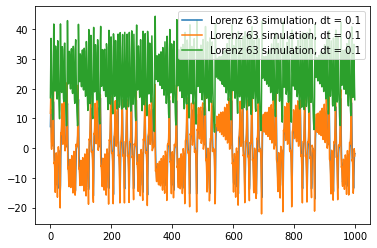

In [5]:
plt.plot(y_pred_all[0], label = 'Lorenz 63 simulation, dt = ' + str(0.1))
plt.legend()

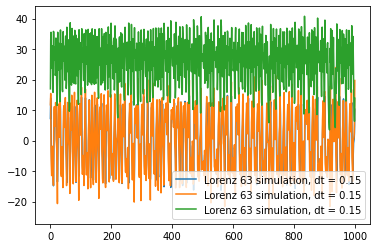

In [6]:
plt.plot(y_pred_all[1], label = 'Lorenz 63 simulation, dt = ' + str(0.15))
plt.legend()

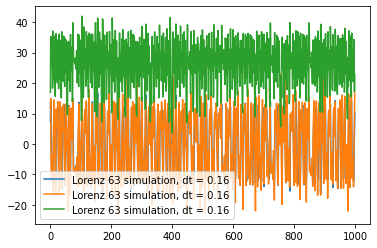

In [7]:
plt.plot(y_pred_all[2], label = 'Lorenz 63 simulation, dt = ' + str(0.16))
plt.legend()

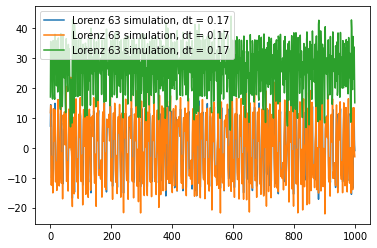

In [8]:
plt.plot(y_pred_all[3], label = 'Lorenz 63 simulation, dt = ' + str(0.17))
plt.legend()

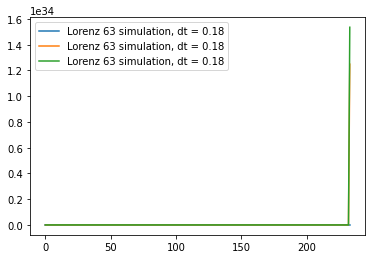

In [9]:
plt.plot(y_pred_all[4], label = 'Lorenz 63 simulation, dt = ' + str(0.18))
plt.legend()

## Perfs of the trained model and integration scheme


# Perfs 2D

In [10]:
#extracting integration scheme params
list_x_all = []
list_y_all = []
list_g_all = []
list_g_arg_all = []
for i in range(len(a_all)):
    a=a_all[i][0,:,:]
    b=b_all[i][0,:]
    c=c_all[i][0,:]

    a[:,0] = c[:] - a[:,:].sum(axis = 1)

    import sympy as sp
    x1,re_w,h  = sp.symbols('x1 re_w h',real=True)
    x2,im_w    = sp.symbols('x2 im_w',real=True)

    xt   = sp.symbols('x1+ix2')
    lamb = re_w+sp.I*im_w

    rz = np.arange(-10,10+0.000001,0.01)
    iz = np.arange(-10,10+0.000001,0.01)
    rz, iz = np.meshgrid(rz,iz)
    z  = rz+iz*1.j

    GRINN = np.zeros_like(z)*np.nan
    list_g = []
    list_x = []
    list_y = []
    gain_arg = []
    for i in tqdm(range(z.shape[0])):
        for j in range(z.shape[1]):
            tmp = 1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b))
            if np.abs(tmp)<1:
                gain_arg.append(np.angle(tmp)/np.angle(np.exp(z[i,j])))
                GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
                list_g.append(GRINN[i,j].real)
                list_x.append(z[i,j].real)
                list_y.append(z[i,j].imag)
    list_x_all.append(list_x)
    list_y_all.append(list_y)
    list_g_all.append(list_g)
    list_g_arg_all.append(gain_arg)

100%|██████████| 2001/2001 [02:49<00:00, 11.80it/s]


In [11]:
GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
gain_argE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = 1+z[i,j]
        if np.abs(tmp)<1:
            gain_argE.append(np.angle(tmp)/np.angle(np.exp(z[i,j])))
            GE[i,j] = np.abs(tmp)
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

100%|██████████| 2001/2001 [00:12<00:00, 160.30it/s]


In [12]:
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
gain_argRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = 1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4))
        if np.abs(tmp)<1:
            gain_argRK4.append(np.angle(tmp)/np.angle(np.exp(z[i,j])))
            GRK4[i,j] = np.abs(tmp)
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

100%|██████████| 2001/2001 [02:38<00:00, 12.66it/s]


(-7.0, 7.0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


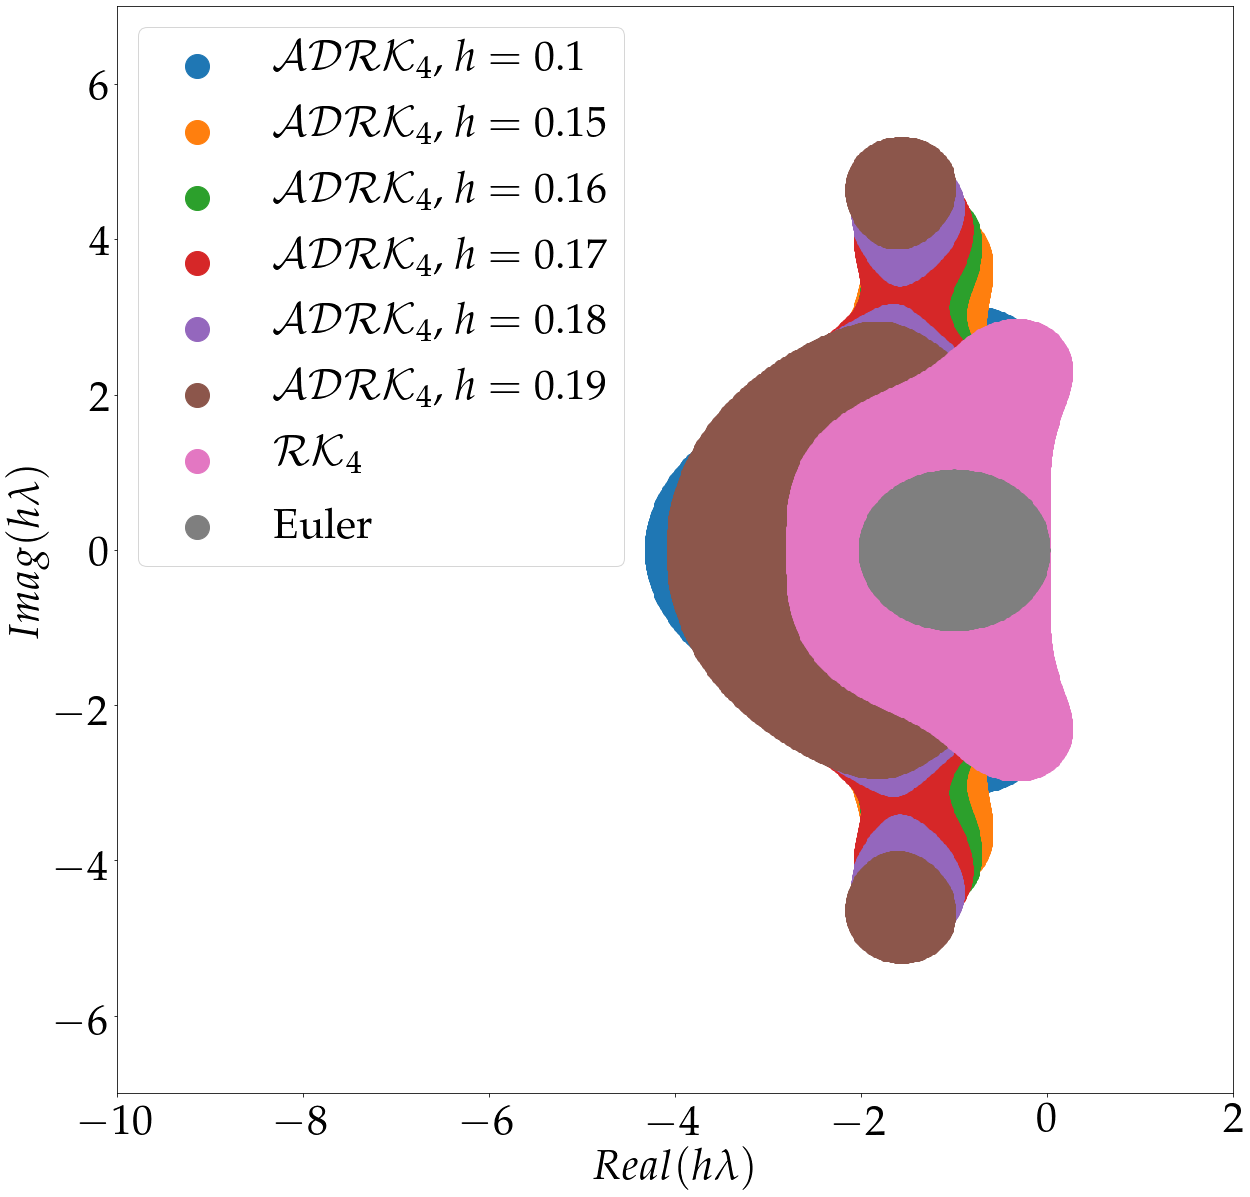

In [13]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
[0.1,0.15,0.16,0.17,0.18,0.19]

plt.scatter(np.array(list_x_all[0]),np.array(list_y_all[0]), label = '$\mathcal{ADRK}_4$, $h=0.1$')
plt.scatter(np.array(list_x_all[1]),np.array(list_y_all[1]), label = '$\mathcal{ADRK}_4$, $h=0.15$')
plt.scatter(np.array(list_x_all[2]),np.array(list_y_all[2]), label = '$\mathcal{ADRK}_4$, $h=0.16$')
plt.scatter(np.array(list_x_all[3]),np.array(list_y_all[3]), label = '$\mathcal{ADRK}_4$, $h=0.17$')
plt.scatter(np.array(list_x_all[4]),np.array(list_y_all[4]), label = '$\mathcal{ADRK}_4$, $h=0.18$')
plt.scatter(np.array(list_x_all[5]),np.array(list_y_all[5]), label = '$\mathcal{ADRK}_4$, $h=0.19$')
plt.scatter(np.array(list_xRK4),np.array(list_yRK4), label = '$\mathcal{RK}_4$')
plt.scatter(np.array(list_xE),np.array(list_yE), label = 'Euler')
plt.legend(markerscale=4.)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
plt.xlim(-10,2)
plt.ylim(-7,7)